In [1]:
import os
os.chdir('../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
from runners.diffusion import Diffusion
from evaluate.fid_score import calculate_fid_given_paths
import os 
from sample import dict2namespace
import yaml
from models.guided_diffusion.unet import UNetModel as GuidedDiffusion_Model
from models.improved_ddpm.unet import UNetModel as ImprovedDDPM_Model
from models.guided_diffusion.unet import EncoderUNetModel as GuidedDiffusion_Classifier
from runners.diffusion import get_beta_schedule, inverse_data_transform
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [5]:

config="imagenet128_guided.yml"
seed=42
rank=0

with open(os.path.join("configs", config), "r") as f:
    config = yaml.safe_load(f)
config = dict2namespace(config)

In [6]:
torch.cuda.set_device(rank)
torch.manual_seed(seed + rank)
np.random.seed(seed + rank)
torch.cuda.manual_seed_all(seed + rank)
torch.backends.cudnn.benchmark = True
device = rank

In [7]:

def show_im(img, size=8):
    plt.figure(figsize=(size, size))
    plt.axis('off')
    plt.imshow(clip_and_plot(img))
    
def clip_and_plot(samples_raw):
    samples = np.clip(samples_raw.permute(0, 2, 3, 1).cpu().numpy() * 255.0, 0, 255).astype(np.uint8)
    nrow = int(np.sqrt(samples_raw.shape[0]))
    image_grid = make_grid(samples_raw, nrow, padding=2)
    return image_grid.cpu().permute(1,2,0)

In [8]:
assert not config.model.is_upsampling
if rank is None:
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
else:
    device = rank
    
betas = get_beta_schedule(
    beta_schedule=config.diffusion.beta_schedule,
    beta_start=config.diffusion.beta_start,
    beta_end=config.diffusion.beta_end,
    num_diffusion_timesteps=config.diffusion.num_diffusion_timesteps,
)
betas = torch.from_numpy(betas).float().to(device)
num_timesteps = betas.shape[0]

In [9]:

model = GuidedDiffusion_Model(
    image_size=config.model.image_size,
    in_channels=config.model.in_channels,
    model_channels=config.model.model_channels,
    out_channels=config.model.out_channels,
    num_res_blocks=config.model.num_res_blocks,
    attention_resolutions=config.model.attention_resolutions,
    dropout=config.model.dropout,
    channel_mult=config.model.channel_mult,
    conv_resample=config.model.conv_resample,
    dims=config.model.dims,
    num_classes=config.model.num_classes,
    use_checkpoint=config.model.use_checkpoint,
    use_fp16=config.model.use_fp16,
    num_heads=config.model.num_heads,
    num_head_channels=config.model.num_head_channels,
    num_heads_upsample=config.model.num_heads_upsample,
    use_scale_shift_norm=config.model.use_scale_shift_norm,
    resblock_updown=config.model.resblock_updown,
    use_new_attention_order=config.model.use_new_attention_order,
)

model = model.to(rank)
map_location = {"cuda:%d" % 0: "cuda:%d" % rank}
ckpt_dir = os.path.expanduser(config.model.ckpt_dir)
states = torch.load(ckpt_dir, map_location=map_location)
model.load_state_dict(states, strict=True)
if config.model.use_fp16:
    model.convert_to_fp16()

classifier = GuidedDiffusion_Classifier(
    image_size=config.classifier.image_size,
    in_channels=config.classifier.in_channels,
    model_channels=config.classifier.model_channels,
    out_channels=config.classifier.out_channels,
    num_res_blocks=config.classifier.num_res_blocks,
    attention_resolutions=config.classifier.attention_resolutions,
    channel_mult=config.classifier.channel_mult,
    use_fp16=config.classifier.use_fp16,
    num_head_channels=config.classifier.num_head_channels,
    use_scale_shift_norm=config.classifier.use_scale_shift_norm,
    resblock_updown=config.classifier.resblock_updown,
    pool=config.classifier.pool,
)
ckpt_dir = os.path.expanduser(config.classifier.ckpt_dir)
states = torch.load(
    ckpt_dir,
    map_location=map_location,
)
classifier = classifier.to(rank)
classifier.load_state_dict(states, strict=True)
if config.classifier.use_fp16:
    classifier.convert_to_fp16()

model.eval()

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (label_emb): Embedding(1000, 1024)
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 256, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1024, out_features=512, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 256, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
         

In [10]:

# batch size 
# n = config.sampling.batch_size
n = 64

init_noise = torch.randn(
    n,
    config.data.channels,
    config.data.image_size,
    config.data.image_size,
    device=device,
)

In [11]:
# Guidded Diffusion - class id & appled classifier scale

# 1 : goldfish, 4.0
# 279: arctic fox, 6.0
# 323: monarch butterfly, 8.0
# 386: african elephant, 8.0
# 130: flamingo, 6.0
# 852: tennis ball, 4.0
# 933: cheeseburger, 6.0
# 562: fountain, 6.0
# 417: balloon, 6.0
# 281: tabby cat, 6.0
# 90:lorikeet, 6.0
# 992: agaric 4.0

In [12]:
# class id
class_int = 263
classes = torch.ones(init_noise.shape[0], dtype=torch.long).to(init_noise.device)*class_int
# classes = torch.randint(low=0, high=config.data.num_classes, size=(init_noise.shape[0],)).to(init_noise.device)
model_kwargs = {"y": classes}



# Sampling Parameters
classifier_scale=4.0
sample_type="dpmsolver++"
thresholding=False
timesteps=6
denoise=False
order=3
skip_type="time_uniform"
lower_order_final=True
scale_dir="/data/guided-diffusion/scale/rbf_ecp_marginal4.0_128/"



In [13]:

from samplers.uni_pc import  model_wrapper, NoiseScheduleVP
from samplers.rbf_ecp_marginal import RBFSolverECPMarginal

noise_schedule = NoiseScheduleVP(schedule="discrete", betas=betas)

def model_fn(x, t, **model_kwargs):
    out = model(x, t, **model_kwargs)
    # If the model outputs both 'mean' and 'variance' (such as improved-DDPM and guided-diffusion),
    # We only use the 'mean' output for DPM-Solver, because DPM-Solver is based on diffusion ODEs.
    if "out_channels" in config.model.__dict__.keys():
        if config.model.out_channels == 6:
            out = torch.split(out, 3, dim=1)[0]
    return out


def classifier_fn(x, t, y, **classifier_kwargs):
    logits = classifier(x, t)
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    return log_probs[range(len(logits)), y.view(-1)]

model_fn_continuous = model_wrapper(
    model_fn,
    noise_schedule,
    model_type="noise",
    model_kwargs=model_kwargs,
    guidance_type="uncond" if classifier is None else "classifier",
    condition=model_kwargs["y"] if "y" in model_kwargs.keys() else None,
    guidance_scale=classifier_scale,
    classifier_fn=classifier_fn,
    classifier_kwargs={},
)
rbf_solver = RBFSolverECPMarginal(
    model_fn_continuous,
    noise_schedule,
    algorithm_type="data_prediction",
    correcting_x0_fn="dynamic_thresholding" if thresholding else None,
    scale_dir=scale_dir
    # variant="bh1"
)
x, [model_hist, lambda_eval, ts_eval] = rbf_solver.sample(
    init_noise,
    steps=(timesteps - 1 if denoise else timesteps),
    order=order,
    skip_type=skip_type,
    lower_order_final=lower_order_final,
    return_intermediate=True
    # denoise_to_zero=denoise,
)

/data/guided-diffusion/scale/rbf_ecp_marginal4.0_128/NFE=6,p=3.npz loaded!


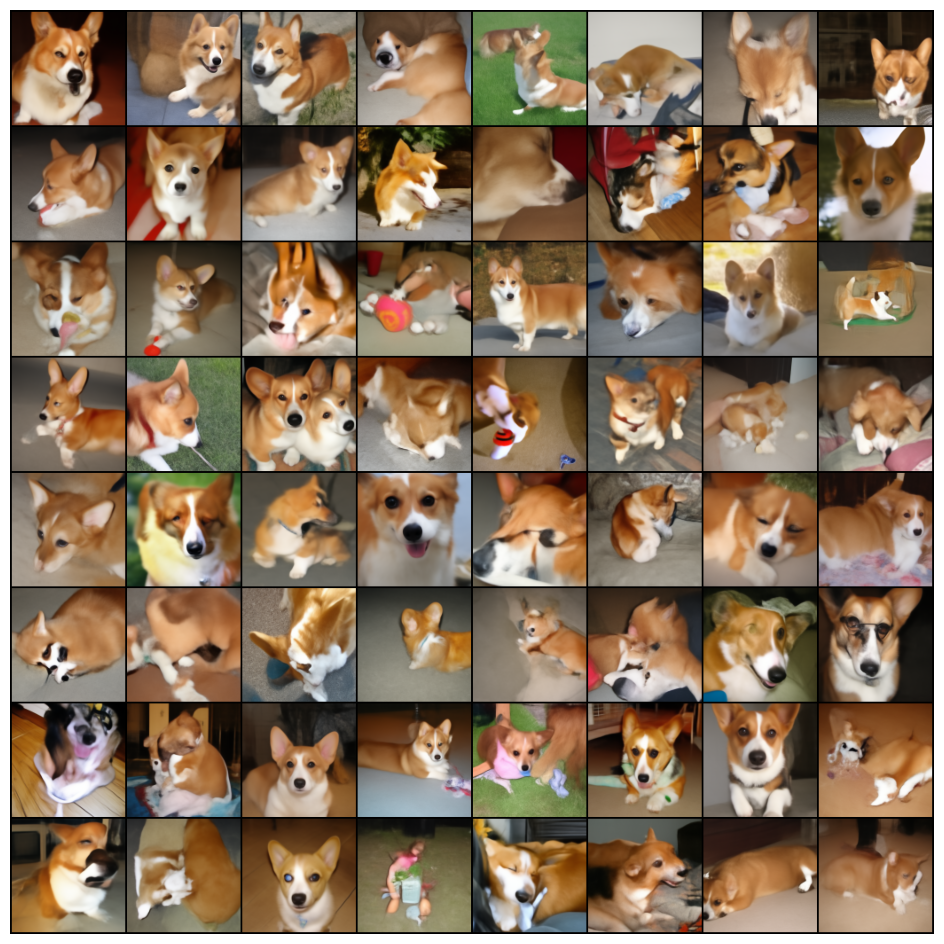

In [14]:
result_rbf = inverse_data_transform(config, model_hist[timesteps-1])
show_im(result_rbf, size=12)


In [ ]:
npz_path = f'plot_data_step6_class{class_int}'

lambda_eval = lambda_eval.cpu().numpy()
model_hist = [m.cpu().numpy() for m in model_hist]
ts_eval = ts_eval.cpu().numpy()

np.savez(
    npz_path, 
    model_hist=model_hist, 
    lambdas=lambda_eval, 
    ts=ts_eval, 
)
print('done')

done
